In [49]:
import pandas as pd
import rrcf
import datetime
import numpy as np
import sys 
#sys.path.append('..')
#sys.path.insert(0, '')
from helpers import nearest_after, optimal_fbeta, calculate_metrics, forest_to_dict
import seaborn as sns
import json

# Carga de datos

En primer lugar, se cargan los ficheros de tráfico de la sede que se desee analizar. Estos ficheros deben haber sido previamente procesados ():

In [2]:
traffic_data = pd.read_csv('../data/bbva_usa_data/BBVA-USA-HOU-MP-M-075945.csv')
traffic_data.head()

/Users/manuelpertejolope/anaconda3/envs/anomaly_detection/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SC_ROUTER,DE_INTERFACE,NU_SPEED,NU_TRAFFIC_INPUT,NU_TRAFFIC_OUTPUT,DT_MEASURE_DATETIME,SC_INTERFACE_TYPE,DE_CUSTOMER_NAME,SD_ADMINISTRATIVE_NUMBER,WEEKEND
0,BBVA-USA-HOU-MP-M-075945,GigabitEthernet0/1,3.072,0.050990,0.657667,2018-03-01 00:00:00,WAN,BBVA,75945,False
1,BBVA-USA-HOU-MP-M-075945,GigabitEthernet0/1,3.072,0.154260,2.824734,2018-03-01 00:05:00,WAN,BBVA,75945,False
2,BBVA-USA-HOU-MP-M-075945,GigabitEthernet0/1,3.072,0.124266,1.215409,2018-03-01 00:10:00,WAN,BBVA,75945,False
3,BBVA-USA-HOU-MP-M-075945,GigabitEthernet0/1,3.072,0.191709,1.525660,2018-03-01 00:15:00,WAN,BBVA,75945,False
4,BBVA-USA-HOU-MP-M-075945,GigabitEthernet0/1,3.072,0.185136,1.620250,2018-03-01 00:20:00,WAN,BBVA,75945,False


A continuación se cargan los datos de incidencias correspondientes a la sede, también previamente procesados()

In [10]:
incidents_filtered = pd.read_csv('../data/bbva_usa_data/incidenciasBBVA-USA.csv')
incidents_filtered.head() 

,TICKET_ID,SERVICE_TYPE,SUBMIT_DATE,LAST_MODIFICATION_DATE,ASSIGNED_SUPPORT_COMPANY,REPORTED_DATE,REPORTED_SOURCE_ID,OPERATING_COMPANY_NAME,CONTACT_COMPANY_NAME,END_USER_COUNTRY,...,OPERATIONAL_CATEGORIZATION_TIER_1,OPERATIONAL_CATEGORIZATION_TIER_2,OPERATIONAL_CATEGORIZATION_TIER_3,CLOSURE_CATEGORIZATION_TIER_1,CLOSURE_CATEGORIZATION_TIER_2,CLOSURE_CATEGORIZATION_TIER_3,VENDOR_GROUP,INF2_HPD_OUTAGE_DURATION,ADMIN_NUMBER,INSTANCEID
0,INC000000577399,User Service Request,2017-03-06 19:49:08,2019-06-25 13:08:44,XO Communications,2017-03-06 19:49:08,15001.0,XO Communications,NaN,Spain,...,Wan Services,MWAN - Failure,Service Reports,CUSTOMER,LAN failures,NaN,XO Communications,338.0,20100322-SITEMPLS-0000075945,AGHAA5V0A57O9AOM4S3USK9DU28MAI
1,INC000000593918,User Service Restoration,2017-04-08 11:07:01,2019-06-25 13:08:44,XO Communications,2017-04-08 11:07:01,15001.0,XO Communications,NaN,Spain,...,Wan Services,MWAN - Performance,Frequent Cuts and Interruptions,PROVIDER,LOCAL LOOP,LL - RESTORED WITHOUT INTERVENTION,XO Communications,1.0,20100322-SITEMPLS-0000075945,AGHAA5V0A57O9AOODIHOEYSBX5FXE9
2,INC000000711346,User Service Restoration,2017-09-18 16:41:51,2019-06-25 13:08:44,XO Communications,2017-09-18 16:41:51,15001.0,XO Communications,NaN,Spain,...,Wan Services,MWAN - Failure,Damage in Backup Line,PROVIDER,LOCAL LOOP,LL - DAMAGED CARD,XO Communications,457.0,20100322-SITEMPLS-0000075945,AGHAA5V0A57O9AOW783QXRGBLPX35N
3,INC000000721052,Query Ticket,2017-09-29 03:09:15,2019-06-25 13:08:44,XO Communications,2017-09-29 03:09:15,15001.0,XO Communications,NaN,Spain,...,Wan Services,Ethernet - Failure,RFO,PROVIDER,LOCAL LOOP,LL - OTHERS,XO Communications,5444.0,20100322-SITEMPLS-0000075945,AGHAA5V0A57OPAOXAUD4IMMAJ4ZXLX
4,INC000001193745,User Service Restoration,2018-05-07 17:59:23,2019-06-25 13:08:44,XO Communications,2018-05-07 17:59:23,15001.0,XO Communications,Telefonica,Spain,...,Wan Services,MWAN - Failure,Damage in Backup Line,PROVIDER,LOCAL LOOP,LL - OTHERS,XO Communications,1.0,20100322-SITEMPLS-0000075945,AGGAA5V0F5WOOAPI33YZPH6PH8GNJ2


# Fase de entrenamiento

Se seleccionan los meses de entrenamiento del modelo. Debido a que para que el funcionamiento del algoritmo sea el deseado, los datos de entrenamiento deben ser lo más "normales" posibles. Entendiéndose "normal" como libres de anomalías, en la medida de lo posible. Por ello se eliminan los 0 presentes en la serie:

In [3]:
traffic_series = pd.Series(traffic_data.NU_TRAFFIC_INPUT.values, index = traffic_data.DT_MEASURE_DATETIME.values)
train_data = traffic_series['2019-02-01 00:00:00':'2019-04-30 23:55:00']
train_data = train_data[train_data != 0] 

In [4]:
num_trees = 50
tree_size = 512
train_index = train_data.index.values
forest = []
while len(forest) < num_trees:
    samples = np.random.choice(train_index, size = (num_trees, tree_size), replace = True)
    trees = [rrcf.RCTree(np.vstack(train_data.loc[sample].values), index_labels = sample) for sample in samples]
    forest.extend(trees) 

# Fase de scoring

Se seleccionan los datos que se desee *scorear*. Se simula un *scoreo* de los datos en *streaming* a través de un bucle *for*:

In [ ]:
test_data = traffic_series['2019-05-01 00:00:00':'2019-11-30 23:55:00']
codisp_no_shingle = pd.Series(0, index = test_data.index.values)

for next_index,next_point in test_data.items():
    for tree in forest:
        tree.insert_point(next_point, index=next_index)
        codisp_no_shingle[next_index] += tree.codisp(next_index)
        tree.forget_point(next_index)
avg_codisp_no_shingle = codisp_no_shingle/num_trees 

El resultado devuelto es un vector de *anomaly scores*. Este vector es convertido a *dataframe* para poder ser guardado y utilizado posteriormente:

In [ ]:
avg_codisp_no_shingle.name = 'Anomaly score'
avg_codisp_no_shingle = avg_codisp_no_shingle.to_frame()
avg_codisp_no_shingle.reset_index(inplace=True)
avg_codisp_no_shingle.rename(columns={'index':'Date'}, inplace=True)
avg_codisp_no_shingle.describe()

In [ ]:
# Se puede guardar para su posterior uso
#avg_codisp_no_shingle.to_csv('../data/bbva_usa_data/anomaly_score_may_nov.csv', index = False)

# Fase de optimización del threshold 

Para calcular el *threshold* óptimo, es necesario hacer cálculo previo de las intervalos asociados a las incidencias.Este intervalo consiste en el lapso de tiempo transcurrido entre la *submit_date* y la *last_resolved_date* de cada incidencia. Las alarmas lanzadas por el algoritmo durante ese intervalo no van a ser tomadas como "falsos positivos":

In [6]:
# Se podrían cargar desde un fichero las anomaly_scores necesarias
avg_codisp_no_shingle = pd.read_csv('../data/bbva_usa_data/anomaly_score_may_nov.csv')

In [37]:
# Nos quedamos con las fechas de test y transformamos a tipo datetime
traffic_data_test = traffic_data[(traffic_data['DT_MEASURE_DATETIME'] >= '2019-05-01 00:00:00') & (traffic_data['DT_MEASURE_DATETIME'] <= '2019-11-30 23:55:00')].copy()
traffic_dates_test = traffic_data_test.DT_MEASURE_DATETIME.values
traffic_dates_test = [datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in traffic_dates_test]

incidents_filtered.sort_values(by = 'SUBMIT_DATE', inplace = True)
submit_dates_test = list(filter(lambda x: (str(x) > '2019-05-01 00:00:00' and str(x) < '2019-11-30 23:55:00'), incidents_filtered.SUBMIT_DATE.values))
resolved_dates_test = list(filter(lambda x: (str(x) > '2019-05-01 00:00:00' and str(x) < '2019-11-30 23:55:00'), incidents_filtered.LAST_RESOLVED_DATE.values))

mapped_submit_dates = [nearest_after(traffic_dates_test, submit_date) for submit_date in submit_dates_test]
mapped_resolved_dates = [nearest_after(traffic_dates_test, resolved_date) for resolved_date in resolved_dates_test]

# Eliminamos fechas que no se corresponden con anomalías reales en la serie de tráfico
mapped_submit_dates.remove('2019-08-02 06:15:00') 
mapped_submit_dates.remove('2019-09-12 03:50:00')
mapped_resolved_dates.remove('2019-09-12 08:00:00')

# Modificamos las incidencias que se mapean al mismo instante, mapeando una de ellas al instante anterior
mapped_submit_dates[0] = '2019-05-11 13:05:00'

# Se elimina la fecha donde el campo last_resolved_date tiene el valor de NaN
mapped_submit_dates.remove('2019-05-11 13:45:00')

# Se calculan las diferencias entre submit_dates y last_resolved_dates
differences_resolved_submit = [np.ceil((datetime.datetime.strptime(mapped_resolved_dates[i], '%Y-%m-%d %H:%M:%S') - datetime.datetime.strptime(mapped_submit_dates[i], '%Y-%m-%d %H:%M:%S')).total_seconds()/60/5) for i in range(len(mapped_resolved_dates))] # Diferencia en nº de intervalos de 5 min.

traffic_data_test['INCIDENT'] = 0.0
traffic_data_test.loc[traffic_data['DT_MEASURE_DATETIME'].isin(mapped_submit_dates), 'INCIDENT'] = 1.0
incidents = traffic_data_test.INCIDENT.values

anomaly_scores_50 = avg_codisp_no_shingle['Anomaly score'].values

Se lanza la función que hace el cálculo del *threshold* óptimo en función de las incidencias registradas:

In [41]:
prev_points = 2 
initial_threshold = 0
last_threshold = 250
beta_value = 2
num_incidents = len(mapped_resolved_dates)

best_threshold = optimal_fbeta(anomaly_scores_50, incidents, prev_points, differences_resolved_submit, initial_threshold, last_threshold, beta_value, num_incidents)
fp, fn, tp, recall, precision, f2_score = calculate_metrics(anomaly_scores_50, incidents, prev_points, best_threshold, differences_resolved_submit, beta_value, num_incidents)

In [43]:
print('El threshold óptimo es: {}'.format(best_threshold))
print('El número de falsas alarmas es: {}'.format(fp))
print('El número incidencias no captadas es: {}'.format(fn))
print('El número de incidencias captadas es: {}'.format(tp))
print('La precisión es {} y el recall {}'.format(precision, recall))
print('La f2_score alcanzada es: {}'.format(f2_score))

El threshold óptimo es: 225.0
El número de falsas alarmas es: 89
El número incidencias no captadas es: 1
El número de incidencias captadas es: 5
La precisión es 0.05319148936170213 y el recall 0.8333333333333334
La f2_score alcanzada es: 0.21186440677966104


# Threshold estadístico

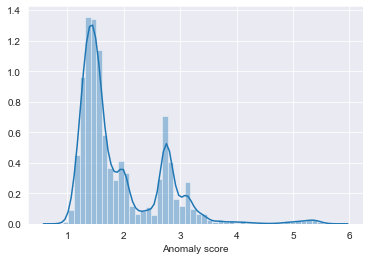

In [50]:
sns.set_style("darkgrid")
ax = sns.distplot(np.log(avg_codisp_no_shingle['Anomaly score']), label = "Anomaly Score")
ax

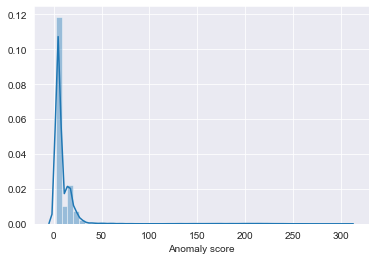

In [51]:
sns.set_style("darkgrid")
ax = sns.distplot(avg_codisp_no_shingle['Anomaly score'], label = "Anomaly Score")
ax

In [53]:
stat_threshold = avg_codisp_no_shingle["Anomaly score"].quantile(.99)
stat_threshold

154.08

In [55]:
# Creamos un archivo json donde guardamos los thresholds y el forest utilizado
forest_dict = forest_to_dict(forest) 
forest_dict["incident_threshold"] = best_threshold
forest_dict["statistic_threshold"] = stat_threshold
with open('../data/bbva_usa_data/75945_GigabitEthernet01_input.json', 'w') as output_file:
    json.dump(forest_dict, output_file)